In [46]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 15, 6

### Membaca Dataset

In [47]:
df = pd.read_csv("C:/Users/yunit/Downloads/Electric_Consumption.csv")
df

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [48]:
df.columns=['Date', 'Consumption']
df=df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) #set date as index
df.head()

,Consumption
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### 1. Visualisasi Data Timeseries

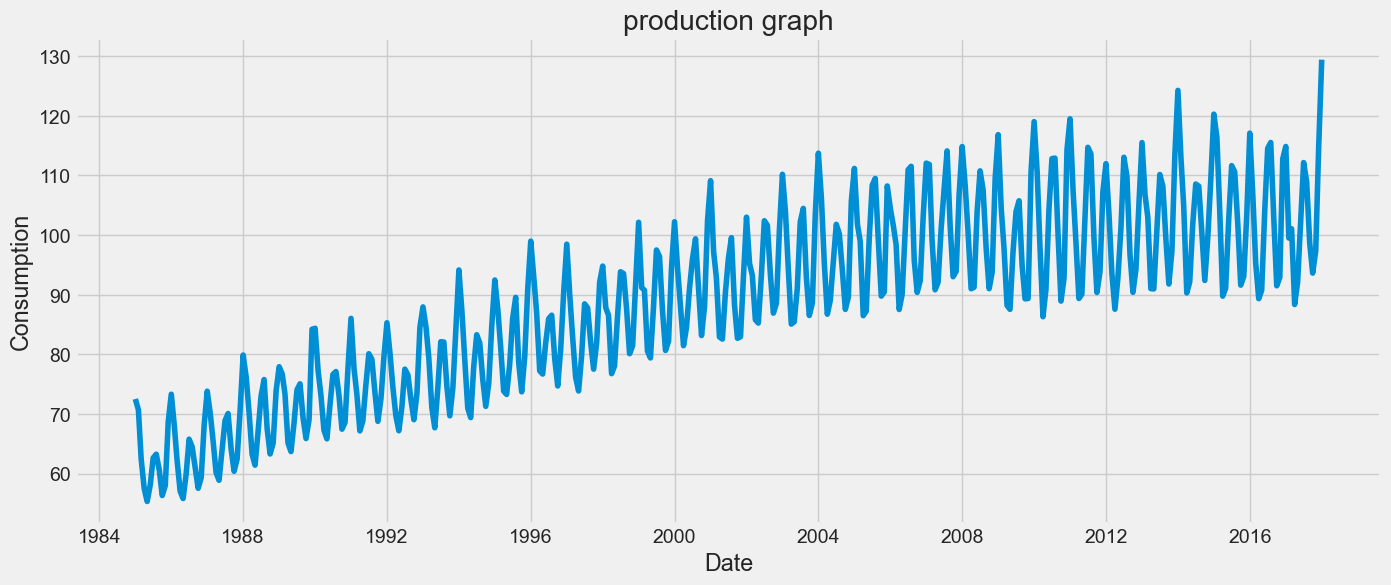

In [49]:
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("production graph")
plt.plot(df)

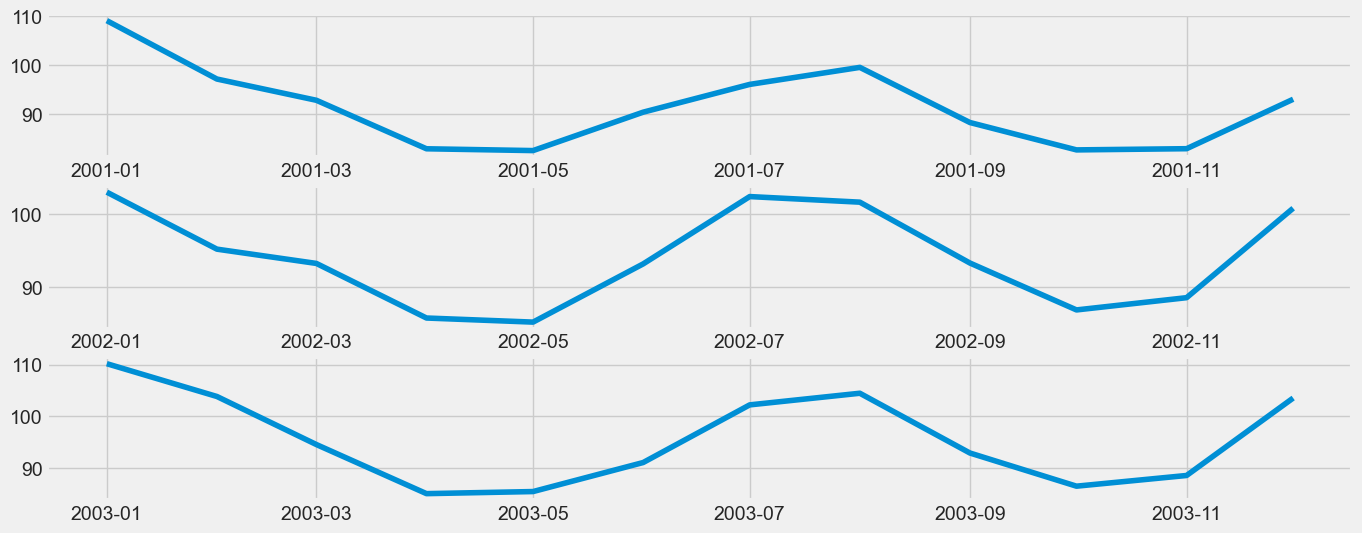

In [50]:
from pandas import Grouper
groups = df['Consumption']['2001':'2003'].groupby(Grouper(freq='A')) # calendar year end 
i = 1
n = len(groups)
#rcParams['figure.figsize'] = 15, 6
for name, group in groups:
    plt.subplot((n*100) + 10 + i)
    i += 1
    plt.plot(group)
plt.show()

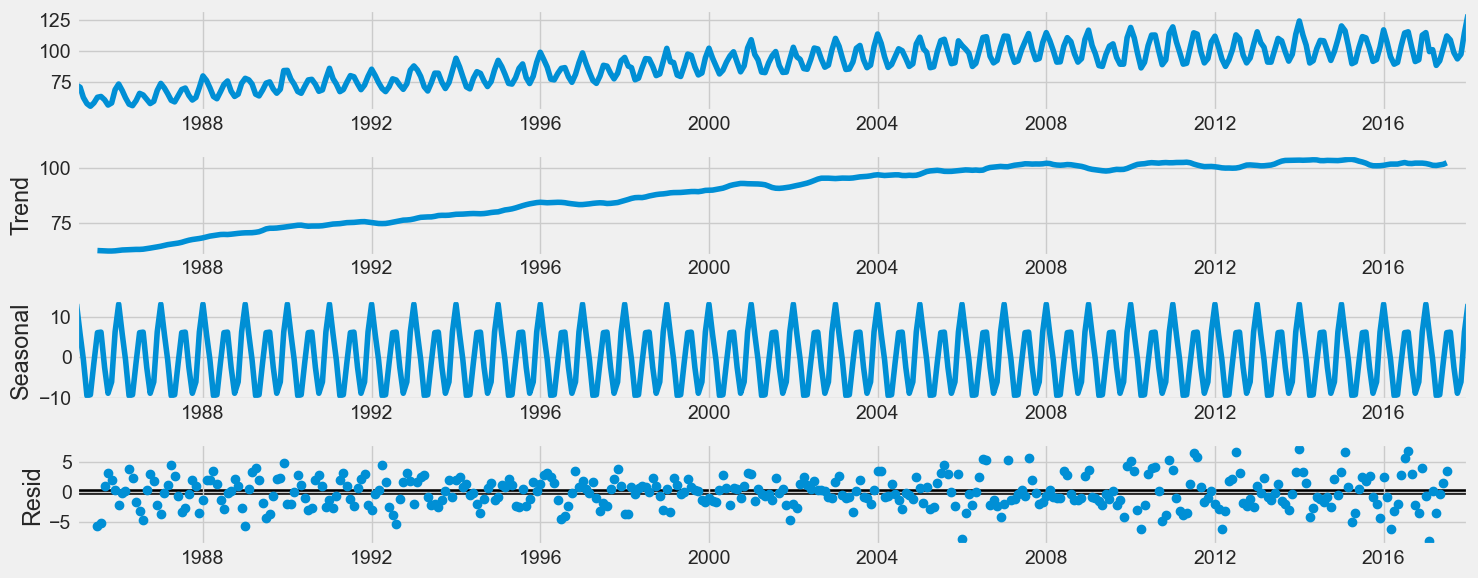

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='additive')
result.plot()
plt.show()

### 2. Stasionerkan Timeseries

In [52]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['Consumption'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

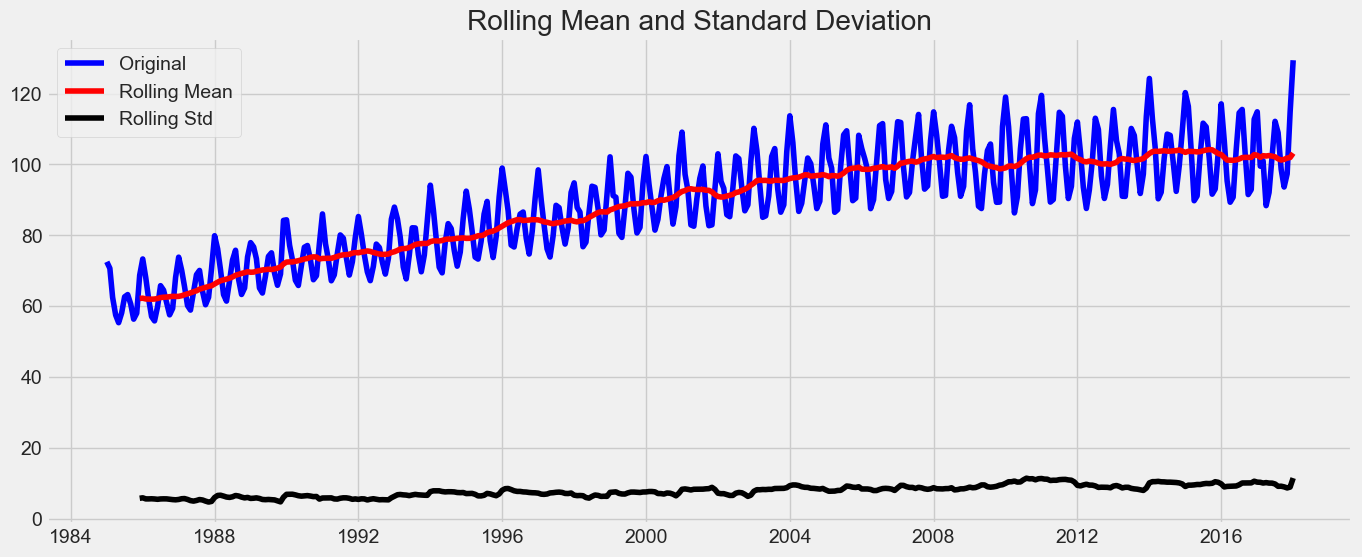

Results of dickey fuller test
Test Statistics                 -2.256990
p-value                          0.186215
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


In [53]:
test_stationarity(df)

In [10]:
df_log = np.log(df)

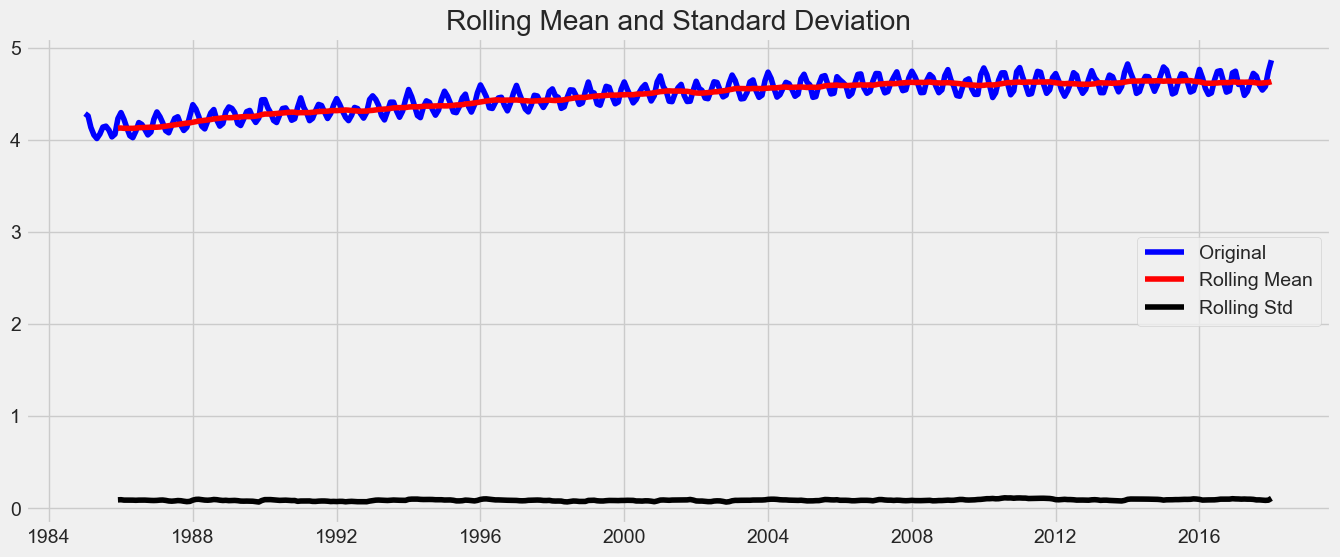

Results of dickey fuller test
Test Statistics                 -3.145360
p-value                          0.023373
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


In [54]:
test_stationarity(df_log)

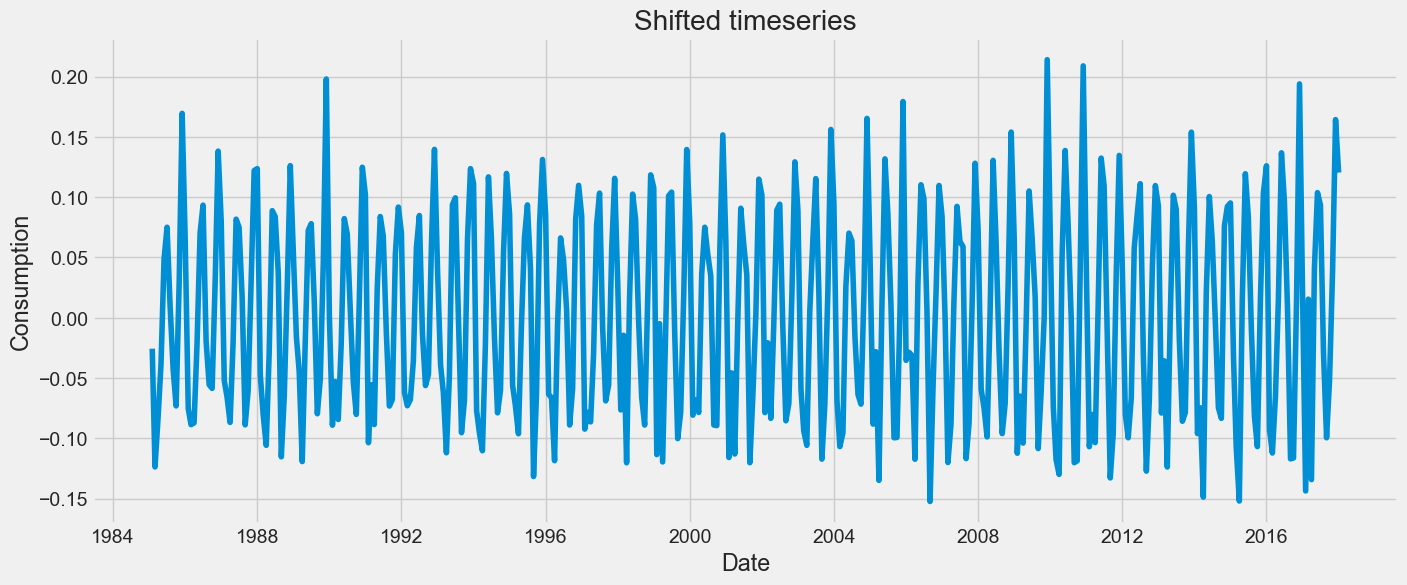

In [55]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)

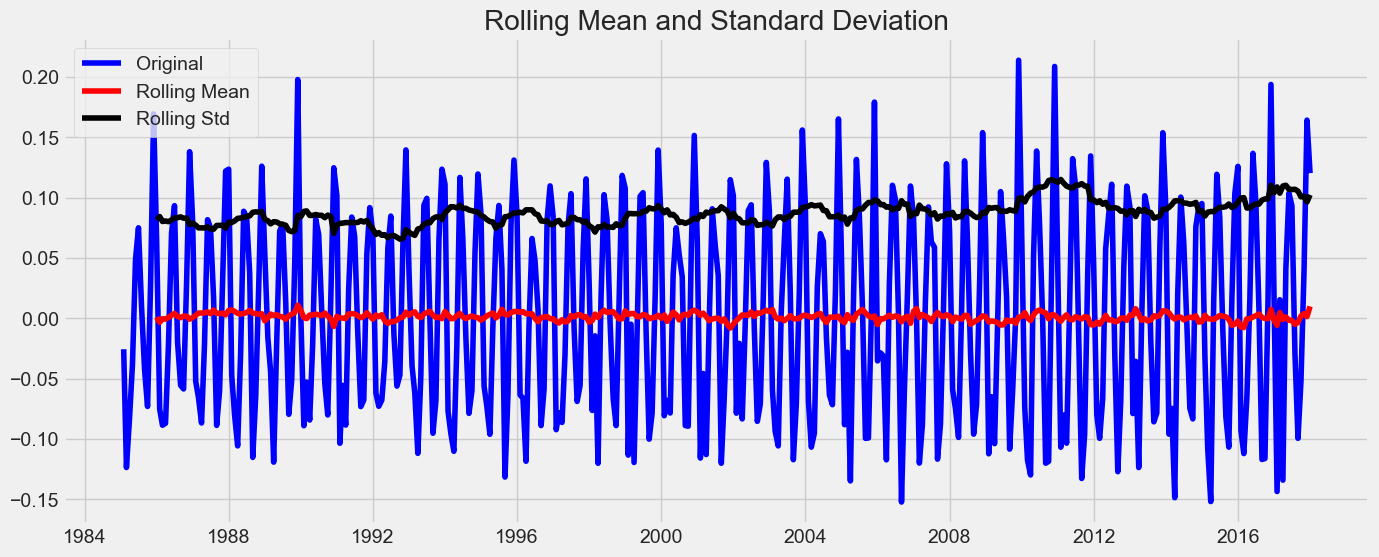

Results of dickey fuller test
Test Statistics               -6.748333e+00
p-value                        2.995161e-09
No. of lags used               1.400000e+01
Number of observations used    3.810000e+02
critical value (1%)           -3.447631e+00
critical value (5%)           -2.869156e+00
critical value (10%)          -2.570827e+00
dtype: float64


In [56]:
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff)

### 3. Cari Parameter Terbaik

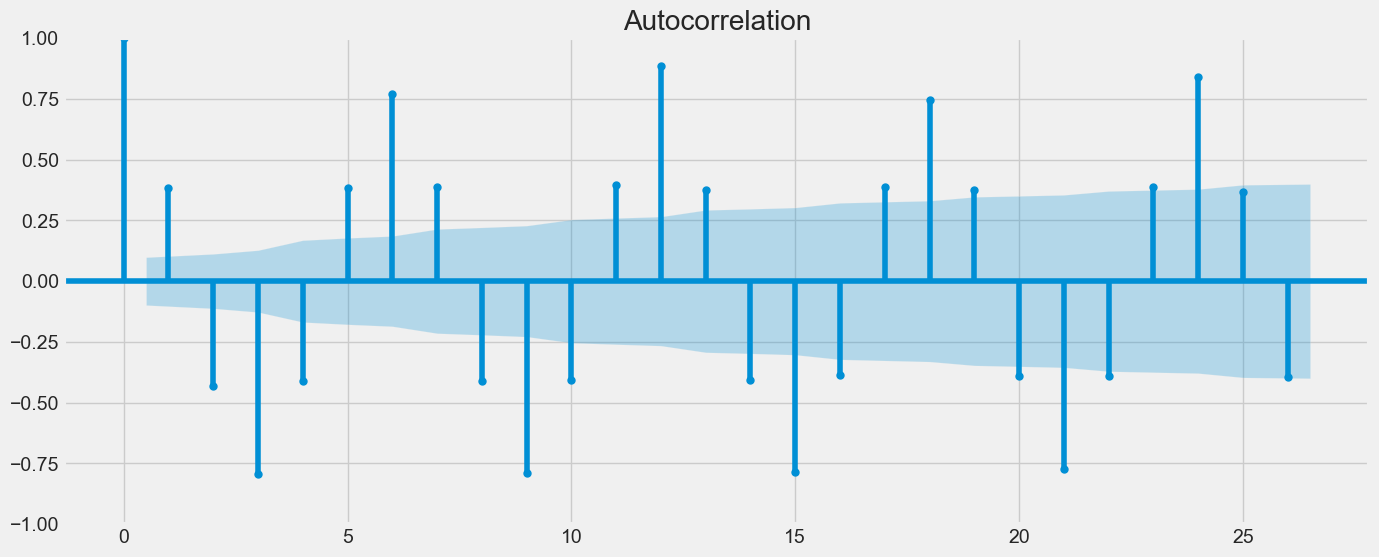

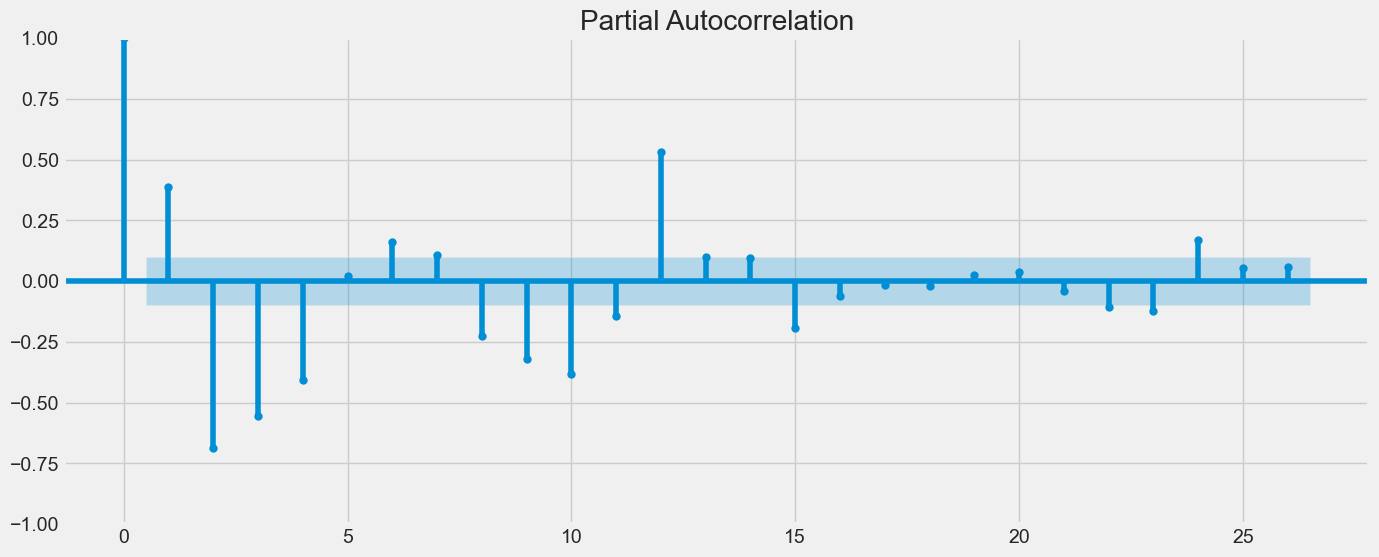

In [57]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
acf = plot_acf(df_log_diff['Consumption'].dropna())
pacf = plot_pacf(df_log_diff['Consumption'].dropna())

### 4. Fitting dan Evaluasi Model

RSS : 0.303998


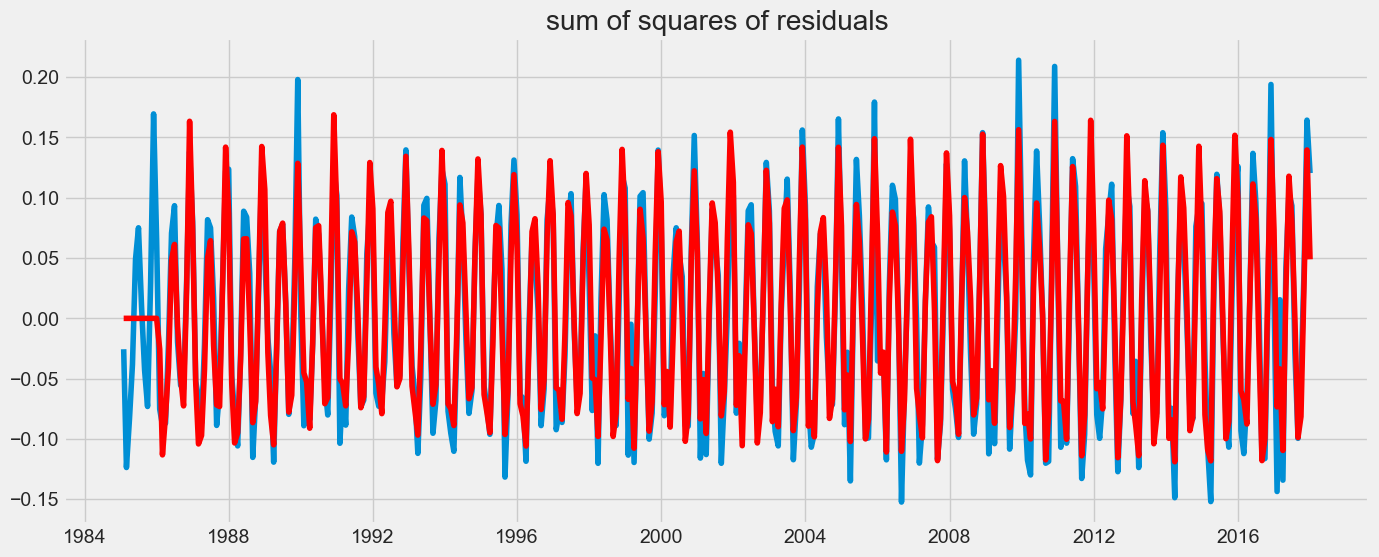

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
order = (0,0,4)
seasonal_order =(2,1,3,12)
model = SARIMAX(df_log_diff, order=order, seasonal_order=seasonal_order)

result_AR = model.fit(disp=0)
plt.plot(df_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.title("sum of squares of residuals")
print('RSS : %f' %sum((result_AR.fittedvalues-df_log_diff["Consumption"])**2))

In [59]:
# Evaluasi Residual
predictions = result_AR.predict()
residuals = [df_log_diff['Consumption'][i]-predictions[i] for i in range(len(df_log_diff['Consumption']))]
results_manual = pd.DataFrame({'Expected':df_log_diff['Consumption'], 'Prediction':predictions,'Residuals':residuals}, index=df_log_diff.index)
results_manual.head()

,Expected,Prediction,Residuals
Date,,,
1985-02-01,-0.025609,0.000000e+00,-0.025609
1985-03-01,-0.123680,6.330493e-12,-0.123680
1985-04-01,-0.083082,3.589363e-11,-0.083082
1985-05-01,-0.038242,4.640787e-11,-0.038242
1985-06-01,0.048954,3.037125e-11,0.048954


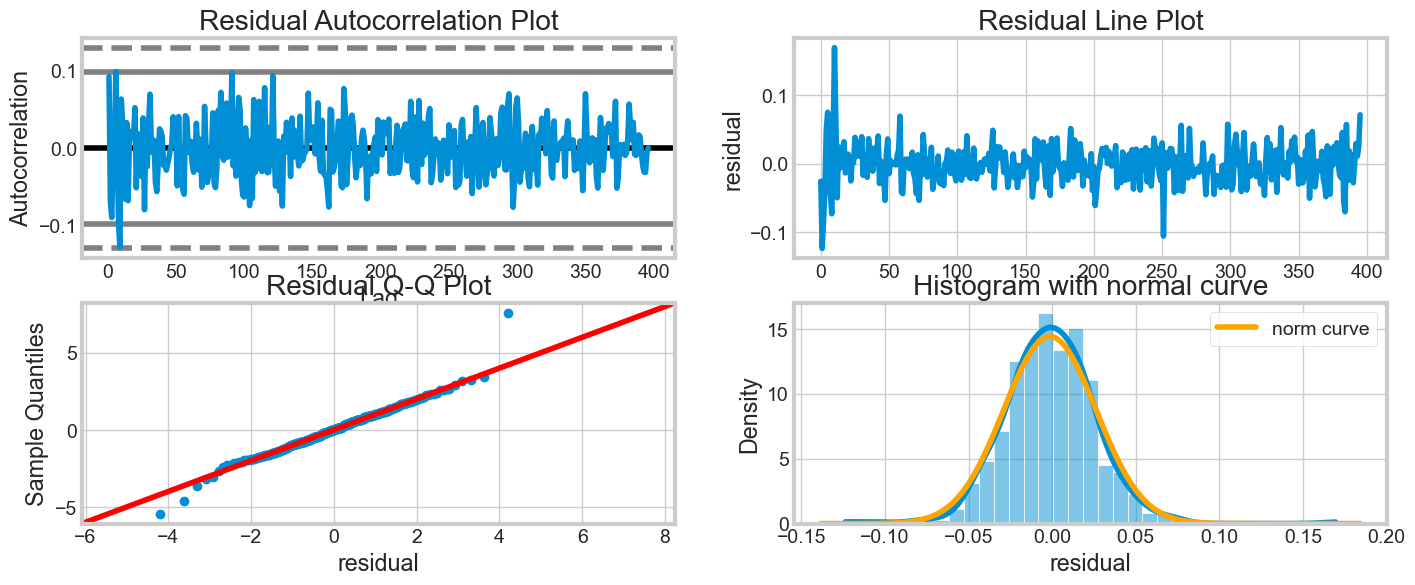

In [60]:
from scipy import stats
import seaborn as sns
sns.set_style("whitegrid")

fig,axes =plt.subplots(2,2)
# autocorrelation plot
pd.plotting.autocorrelation_plot(residuals, ax=axes[0,0])
axes[0,0].set(title='Residual Autocorrelation Plot')


# line plot
axes[0,1].plot(residuals)
axes[0,1].set(title='Residual Line Plot', ylabel='residual')


# Q-Q Plot
import statsmodels.api as sm
sm.qqplot(np.array(residuals),stats.t, fit=True, line="45", ax=axes[1,0])
axes[1,0].set(title='Residual Q-Q Plot', xlabel='residual')

# histogram plot with corresponding normal curve
sns.histplot(residuals, ax=axes[1,1], stat='density', kde=True)
axes[1,1].set(title='Histogram with normal curve', xlabel='residual')
# plot corresponding normal curve
xmin, xmax=plt.xlim() # the maximum x values from the histogram above
x=np.linspace(xmin, xmax, 100) 
mu, std = stats.norm.fit(residuals)
p=stats.norm.pdf(x, mu, std) #calculate the y values for the normal curve
axes[1,1].plot(x, p, color='orange',label='norm curve')
axes[1,1].legend(loc='best')
plt.show()

### 5. Tampilkan Prediksi

In [70]:
forecast_steps = 96  # Jumlah langkah waktu yang ingin diprediksi
forecast_values= result_AR.forecast(steps=forecast_steps)

inverse_diff = np.cumsum(forecast_values) + df_log["Consumption"].iloc[-1]
inverse_log = np.exp(inverse_diff)
inverse_log

2018-02-01    114.221868
2018-03-01    105.354465
2018-04-01     92.242248
2018-05-01     93.640345
2018-06-01    104.379245
                 ...    
2025-09-01    106.648449
2025-10-01     97.994408
2025-11-01    101.474670
2025-12-01    117.501985
2026-01-01    127.738903
Freq: MS, Name: predicted_mean, Length: 96, dtype: float64

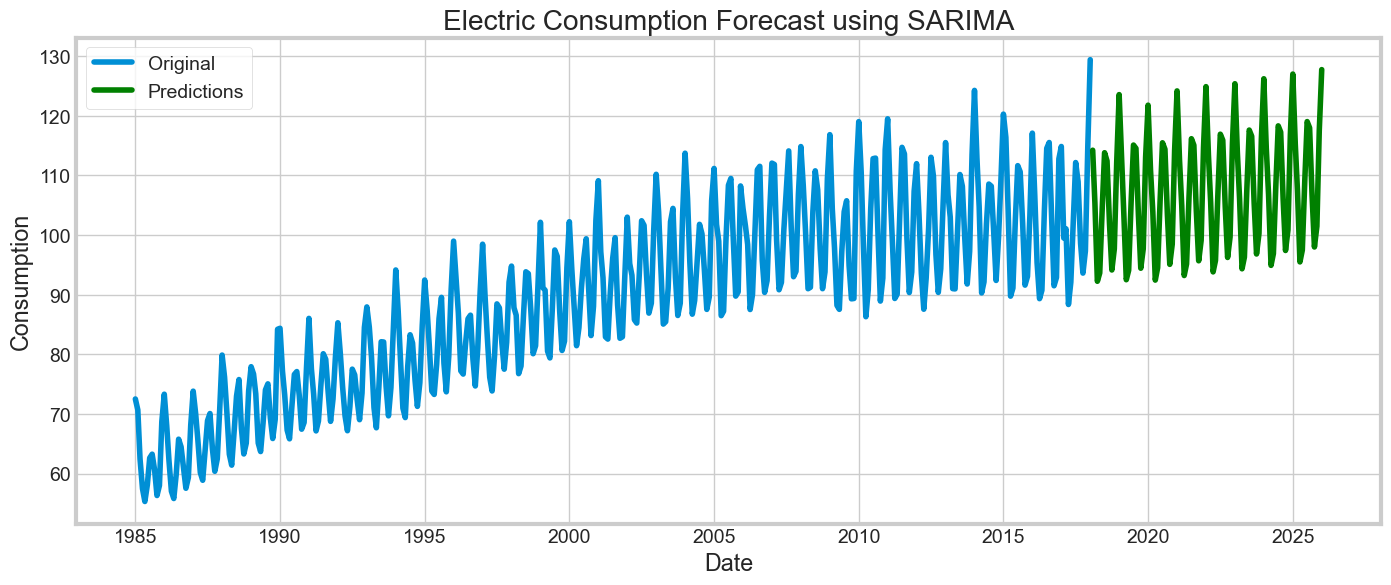

In [71]:
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("Electric Consumption Forecast using SARIMA")
plt.plot(df, label='Original')
plt.plot(inverse_log, color = 'green', label='Predictions')
plt.legend()